# Diabetes Prediction

In [1]:
import numpy as np
import pandas as pd
import requests
import altair as alt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline
from ucimlrepo import fetch_ucirepo 
from sklearn.metrics import (
    accuracy_score, make_scorer, fbeta_score, 
    recall_score, precision_score, ConfusionMatrixDisplay
)
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

## Summary

In this project we attempt to build a model to predict diabetes disease. We compared a decision tree model and naive bayes model and found the decision tree is stronger in this context. We used f2-score as our scoring function because detecting diabetes is the priority: a false negative could be much worse then a false positive.

In the test dataset: the decision tree model correctly detected 8283 of 10604 positive cases (recall rate is about 78%). This result does come at a fairly significant cost in terms of false positives (precision rate is about 30%) with 19650 false positives. Depending on the actual cost of false positive this may need significant improvement to be a viable screening model.

## Introduction

In Canada and the USA approximately 10% of people are living with diabetes. In Canada in 2023 approximately 3.7 million people were living with diabetes and in the USA in 2021 approzimately 38.4 million people were living with diabetes. In the USA it is the 8th leading cause of death. Globally an estimated 44% of people living with diabetes are undiagnosed.

In this project we try to predicted diabetes disease based on common health factors. A reliable model could help to prescreen people and recommend following up with a physician for people who are at risk. Given the large number of people living with undiagnosed diabetes this could potentially have a significant positive impact of world health.

## Methods and Results

The analysis uses the CDC Behavioural Risk Factor Surveillance System (BRFSS) 2015 Diabetes Health Indicators dataset (UCI ID 891), containing 253,680 survey responses with 21 health-related features and a binary diabetes outcome (0 = no diabetes/pre-diabetes, 1 = diabetes).  
No missing values were present and all features were already encoded numerically. The target classes are heavily imbalanced (≈86% non-diabetic, ≈14% diabetic).

### EDA
Group-wise mean differences revealed the strongest risk factors for diabetes:
- PhysHlth (days of poor physical health)
- BMI
- Age
- MentHlth (days of poor mental health)
- GenHlth (self-rated general health)

Weakest factors
- HvyAlcoholConsump
- Fruits
- Veggies
- PhysActivity
- Education
- Income

Box plots of the top five predictors clearly separate the diabetic and non-diabetic groups.

### Modeling Approach
The data were split 70/30 into training and test sets with stratification on the target.  
Two classifiers were trained and tuned using 5-fold cross-validated grid search with **f2-score** as the scoring metric. We chose to use f2-score because it is more appropriate than accuracy or f1 because we don't want to miss true positives.

1. **Decision Tree** (class_weight='balanced')  
   Hyperparameters: max_depth ∈ {6,8,10,12,14}, min_samples_leaf ∈ {175, 200, 225, 250}  
   **Best parameters**: max_depth=10, min_samples_leaf=200  
   **Best CV f2-score** = 0.5908

2. **Bernoulli Naive Bayes** (with StandardScaler preprocessing)  
   Hyperparameters: alpha ∈ {1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4}  
   **Best parameters**: alpha=1e-3  
   **Best CV f2-score** = 0.4453

### Results
|         Model | Test Accuracy | Test f2-score | Test recall | Test precision |
|--------------:|--------------:|--------------:|------------:|---------------:|
| Decision Tree |        0.7113 |    **0.5887** |  **0.7811** |         0.2965 |
|   Naive Bayes |    **0.8220** |        0.4457 |      0.4640 |     **0.3849** |

### Load Data

In [2]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 


### Save Raw Data

In [3]:
## Save Raw Data
X.to_csv("../data/raw/diabetes_raw_features.csv")
y.to_csv("../data/raw/diabetes_raw_targets.csv")

### Data Wrangling

In [4]:
# No major cleaning needed — dataset is already very clean!
# Combine features and targets to get a overview of the full data set
df = X.copy()
df['diabetes'] = y

# Quick info
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253680 non-null  int64
 15  PhysHlth              253680 non-n

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,diabetes
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


### Data Summary

In [5]:
df.describe()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,diabetes
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,...,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875,0.139333
std,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,...,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148,0.346294
min,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000,0.000000
50%,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000,0.000000
75%,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000,0.000000
max,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000,1.000000


Too many features, and not all of them are useful. We want to select a few features that have the highest impact. Identify the top risk factors by average value for people with and without diabetes. This way, we can understand which features associated with people with diabetes have the greatest impact compared to those without diabetes.

A positive 'difference' value means the feature has a higher average value in people with diabetes

In [6]:
summary = df.groupby('diabetes').mean().T
summary['difference'] = summary[1] - summary[0]
summary.sort_values('difference', ascending=False)

diabetes,0,1,difference
PhysHlth,3.641082,7.954479,4.313397
BMI,27.805770,31.944011,4.138241
Age,7.814065,9.379053,1.564988
MentHlth,2.978034,4.461806,1.483772
GenHlth,2.385185,3.290981,0.905796
HighBP,0.376602,0.752674,0.376072
HighChol,0.384297,0.670118,0.285822
DiffWalk,0.135361,0.371216,0.235855
HeartDiseaseorAttack,0.073351,0.222882,0.149531
Smoker,0.431019,0.518220,0.087201


### Visualizations

In [7]:
df[['diabetes']].value_counts()

diabetes
0           218334
1            35346
Name: count, dtype: int64

In [8]:
# EDA on relative count of diabetes records
df_sample = df.sample(n=1000, random_state=522)

alt.Chart(df_sample).mark_bar().encode(
    x=alt.X('diabetes:N', title='Has Diabetes'),
    y='count()'
).properties(title='Diabetes Prevalence in Dataset')

alt.Chart(...)

As the analysis above, we can ignore some of the features

In [9]:
np.random.seed(522)

drop_cols = ['HvyAlcoholConsump', 'Fruits', 'Veggies','PhysActivity','Education','Income']

df_clean = df.drop(columns=drop_cols)

In [10]:
alt.data_transformers.enable('vegafusion')

top5 = ['PhysHlth', 'BMI', 'Age', 'MentHlth', 'GenHlth']
plot_data = df_sample.melt(id_vars='diabetes', value_vars=top5)

alt.Chart(plot_data).mark_boxplot().encode(
    x='diabetes:N',
    y='value:Q',
    color='diabetes:N'
).facet(
    column='variable:N'
).properties(
    title='Top 5 Predictors: Diabetic vs Non-Diabetic',
)



alt.FacetChart(...)

In [11]:
# split the data 70-30 split
train_df, test_df = train_test_split(
    df_clean, test_size=0.3, random_state=522, stratify=df_clean['diabetes']
)

# check if processed folder exists
processed_data_path = "../data/processed"

if not os.path.exists(processed_data_path):
    os.makedirs(processed_data_path)

# Save processed data
train_df.to_csv(processed_data_path+"/diabetes_train.csv", index=False)
test_df.to_csv(processed_data_path+"/diabetes_test.csv", index=False)

In [12]:
X_train = train_df.drop('diabetes', axis=1)
y_train = train_df['diabetes']
X_test  = test_df.drop('diabetes', axis=1)
y_test  = test_df['diabetes']

### Classification Analysis

In [13]:
f2_scorer = make_scorer(fbeta_score, beta=2)

In [14]:
tree = DecisionTreeClassifier(random_state=522, class_weight='balanced')

tree_params = {
    'max_depth': [6, 8, 10, 12, 14],
    'min_samples_leaf': [175, 200, 225, 250]
}

tree_grid = GridSearchCV(tree, tree_params, cv=5, scoring=f2_scorer, n_jobs=-1)
tree_grid.fit(X_train, y_train)

best_tree = tree_grid.best_estimator_
print("Best Decision Tree params:", tree_grid.best_params_)
print("Best CV f2-score:", tree_grid.best_score_.round(4))

Best Decision Tree params: {'max_depth': 10, 'min_samples_leaf': 200}
Best CV f2-score: 0.5908


In [15]:
preprocessor = make_column_transformer(
    (StandardScaler(), X_train.columns)
)

nb_pipe = make_pipeline(
    preprocessor,
    BernoulliNB()
)

nb_params = {'bernoullinb__alpha': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]}

knn_grid = GridSearchCV(nb_pipe, nb_params, cv=5, scoring=f2_scorer, n_jobs=-1)
knn_grid.fit(X_train, y_train)

best_nb = knn_grid.best_estimator_
print("Best NB k:", knn_grid.best_params_)
print("Best CV f2-score:", knn_grid.best_score_.round(4))

Best NB k: {'bernoullinb__alpha': 0.001}
Best CV f2-score: 0.4453


In [16]:
models = {
    'Decision Tree': best_tree,
    'Naive Bayes': best_nb
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    results.append({
        'Model': name,
        'Test Accuracy': accuracy_score(y_test, y_pred).round(4),
        'Test f2-score': fbeta_score(y_test, y_pred, beta=2).round(4),
        'Test recall': recall_score(y_test, y_pred).round(4),
        'Test precision': precision_score(y_test, y_pred).round(4),
    })

score_df = pd.DataFrame(results)
score_df

,Model,Test Accuracy,Test f2-score,Test recall,Test precision
0,Decision Tree,0.7113,0.5887,0.7811,0.2965
1,Naive Bayes,0.8220,0.4457,0.4640,0.3849


### Result Visualizations

In [17]:
score_melt = score_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

alt.Chart(score_melt).mark_bar().encode(
    x='Model:N',
    y='Score:Q',
    color='Model:N',
    column='Metric:N'
).properties(
    title='Decision Tree vs Naive Bayes Performance on Test Set'
)

alt.Chart(...)

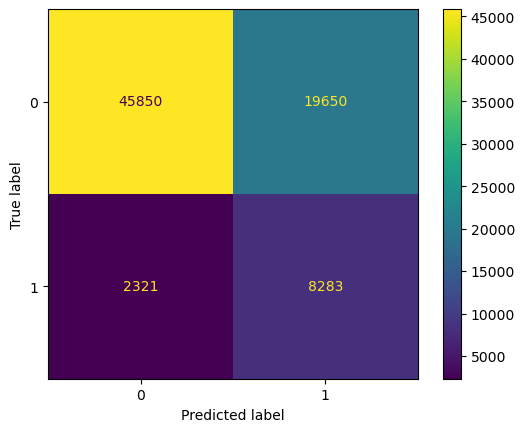

In [18]:
ConfusionMatrixDisplay.from_estimator(
    best_tree,
    X_test,
    y_test,
    values_format="d",
)

## Discussion

The current performance of the tree model is likely already good enough to offer some benefit in the real world given the large number of people with undiagnosed diabetes. However the the recall score likely could be impoved on and the precision score definitely leaves something to be desired. 

Further improvements to predicting diabetes could likely be found by 1) trying a wider veriety of model type and using a wider hyperperameter search 2) possibly through more feature engineering. 

Also, this type of model could be made more usable if a smaller set of the most easy to obtain features were used. Some study is needed to determine the smallest number of easy to obtain features that doesn't significantly reduce model performance.

## References

[1] “Python 3.12.12 documentation,” 2021-2025. Accessed: Nov. 19, 2025,
https://docs.python.org/3.12/reference/index.html

[2] “Cdc diabetes health indicators.” https://doi.org/10.24432/C53919.
Python library utilized to access the CDC diabetes dataset. Further docu-
mentation on the library is located at https://github.com/uci-ml-repo/
ucimlrepo.

[3] S. Dane and A. Teboul, “Diabetes health indicators
dataset.” https://www.kaggle.com/datasets/alexteboul/
diabetes-health-indicators-dataset/data, 2021. Accessed: Nov.
18, 2025.

[4] N. B. Rios, I. Hora, L. S. Geiss, E. W. Gregg, and A. Albright, “In-
cidence of end-stage renal disease attributed to diabetes among persons
with diagnosed diabetes — united states and puerto rico,” Nov 3 2017.
http://dx.doi.org/10.15585/mmwr.mm6643a2.

[5] “Snapshot of diabetes in canada, 2023.” https://www.canada.ca/
en/public-health/services/publications/diseases-conditions/
snapshot-diabetes-canada-2023.html, 2023. Accessed: Nov 19, 2025.

[6] L. K. Stafford, A. Gage, Y. Y. Xu, M. Conrad, I. B. Beltran, and E. J.
Boyko, “Global, regional, and national cascades of diabetes care, 2000–23:
a systematic review and modelling analysis using findings from the global
burden of disease study,” The Lancet Diabetes & Endocrinology, no. 13(11),
pp. 924–934, 2025.